In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, KFold, cross_val_score
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve,\
roc_auc_score,precision_recall_fscore_support

import optuna

/home/ivo/Programming_Personal_Projects/Credit_Risk_Models/.env_cred/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
sns.set()
import os
PROJ_PATH = os.path.abspath(os.path.pardir)
DATA_FOLDER_PATH = os.path.join(PROJ_PATH,"Data Set")

In [12]:
DATA_FOLDER_PATH

'/home/ivo/Programming_Personal_Projects/Credit_Risk_Models/Data Set'

In [13]:
X_train = pd.read_csv(os.path.join(DATA_FOLDER_PATH,"X_train.csv"))
X_test = pd.read_csv(os.path.join(DATA_FOLDER_PATH,"X_test.csv"))
Y_train = pd.read_csv(os.path.join(DATA_FOLDER_PATH,"Y_train.csv"))
Y_test = pd.read_csv(os.path.join(DATA_FOLDER_PATH,"Y_test.csv"))

In [14]:
X_train.head()

,person_age,person_income,person_home_ownership_enc,person_emp_length,loan_intent_enc,loan_grade_enc,loan_amnt,loan_int_rate,loan_percent_income
0,26,72000,3,8.0,4,0,7000,9.32,0.10
1,22,75000,3,2.0,1,1,19600,12.42,0.26
2,32,86000,3,4.0,1,2,1600,13.23,0.02
3,28,80569,0,2.0,1,1,4000,9.63,0.05
4,33,41196,2,0.0,5,2,3300,12.99,0.08


# Baseline Model - Logistic Regression + Threshold

In [4]:
reg_base=LogisticRegression()

In [15]:
reg_base.fit(X_train, np.ravel(Y_train))

LogisticRegression()

In [16]:
for name,coef in zip(X_train.columns,np.ravel(reg_base.coef_)):
    print("Feature Name: {}, Coefficient Estimation: {}\n".format(name,coef))

Feature Name: person_age, Coefficient Estimation: -6.186348830084245e-08

Feature Name: person_income, Coefficient Estimation: -4.161450131374798e-05

Feature Name: person_home_ownership_enc, Coefficient Estimation: 1.533400101459756e-08

Feature Name: person_emp_length, Coefficient Estimation: -2.792063455238959e-08

Feature Name: loan_intent_enc, Coefficient Estimation: -1.9694796539003056e-08

Feature Name: loan_grade_enc, Coefficient Estimation: 4.5144776572456986e-08

Feature Name: loan_amnt, Coefficient Estimation: 0.00011194766763487945

Feature Name: loan_int_rate, Coefficient Estimation: 9.10007020832563e-08

Feature Name: loan_percent_income, Coefficient Estimation: 2.5703197768503884e-09



Given that $$\text{Logistic}(X)=\frac{1}{1+\exp(-\textbf{X}\beta)}$$

with loan default being labeled as 1 in our dataset, those features with negative estimations, when increased, will diminish the probability of default.
For example, income, age, employment length, as they increase they diminish the prob of default, which makes sense. Check [this link](https://online.stat.psu.edu/stat462/node/207/) for further information on the interpretability of this model and associated hypothesis tests.

In [17]:
Y_pred=reg_base.predict(X_test)

In [18]:
preds= reg_base.predict_proba(X_test)
preds

array([[0.9475259 , 0.0524741 ],
       [0.79904254, 0.20095746],
       [0.84350198, 0.15649802],
       ...,
       [0.72162612, 0.27837388],
       [0.79082847, 0.20917153],
       [0.93086398, 0.06913602]])

In [19]:
reg_base.classes_ # loan_status of 1 is default.

array([0, 1])

In [20]:
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

In [21]:
preds_df["loan_status"] = preds_df["prob_default"].apply(lambda x: 1 if x > 0.5 else 0)

In [22]:
preds_df.head()

,prob_default,loan_status
0,0.052474,0
1,0.200957,0
2,0.156498,0
3,0.325126,0
4,0.160817,0


In [23]:
preds_df["loan_status"].value_counts() # we predict 294 defaults

0    5434
1     294
Name: loan_status, dtype: int64

# Measuring the Performance of our Model

In [24]:
# Classification Report follows the order from reg_base.classes_
# Label 0, Label 1, etc.

target_names = ['Non-Default', 'Default']
print(classification_report(Y_test,preds_df["loan_status"], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      4465
     Default       0.72      0.17      0.27      1263

    accuracy                           0.80      5728
   macro avg       0.76      0.57      0.58      5728
weighted avg       0.79      0.80      0.75      5728



**Positive Predictive Value** (or **Precision**):
$$\text{PPV}=\frac{TP}{TP+FP}$$ 
+ The proportion of True Positives out of all Classified Positives. The False Positives are Data Negatives the model classified as Positives.

**Negative Predictive Value**:
$$\text{NPV}=\frac{TN}{TN+FN}$$ 
+ The proportion of True Negatives out of all Classified Negatives.

**True Positive Rate** (or **Recall**):
$$\text{TPR}=\frac{TP}{TP+FN}$$
+ Proportion of Positives from all Data Positives. Here, FN are Classified Negatives which are in fact Data Positives.

**True Negative Rate** (or **Specificity**):
$$\text{TNR}=\frac{TN}{TN+FP}$$
+ Proportion of Negatives from all Data Negatives. Here, FP are Classified Positives which are in fact Data Negatives.

**F1-Score**:
$$F1=2\times \frac{PPV+TPR}{PPV\times TPR}$$
+ It's the harmonic mean of Precision and Recall. Used when in the presence of imbalanced classes. 

In [25]:
# Print the accuracy score the model
print(reg_base.score(X_test, Y_test))

0.8018505586592178


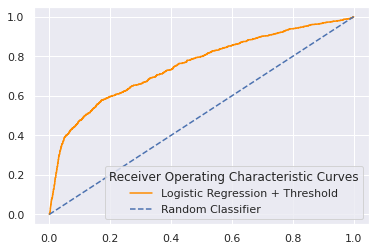

In [26]:
# Plot the ROC curve of the probabilities of default
prob_default =preds_df["prob_default"] # preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(Y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange', 
         label = "Logistic Regression + Threshold")


plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")

plt.legend(title='Receiver Operating Characteristic Curves')

plt.show()

In [27]:
# pd.DataFrame({'fallout':fallout, 
#               'sensitivity':sensitivity}).to_csv(r"..\Data Set\Roc_Logistic.csv", 
#                                                  index=False)


In [28]:
# Compute the AUC and store it in a variable
auc = roc_auc_score(Y_test, prob_default)
auc

0.7528467654201456

In [29]:
# number of loan defaults from the prediction data
n_defaults = preds_df["loan_status"].value_counts()[1]

# default recall - True Default (Positive) Rate : proportion of correctly identified defaults
# out of all data defaults
default_recall = precision_recall_fscore_support(Y_test,preds_df["loan_status"])[1][1]

avg_loan_amnt=X_test["loan_amnt"].mean()

# Calculate the estimated impact of the new default recall rate

default_rr=n_defaults * avg_loan_amnt * (1 - default_recall)

print("The estimated average loss of misidentified defaults is {:,.4f} €".format(default_rr))
    

The estimated average loss of misidentified defaults is 2,355,525.5305 €


In [31]:
precision_recall_fscore_support(Y_test,preds_df["loan_status"])

(array([0.80640412, 0.71768707]),
 array([0.98141097, 0.16706255]),
 array([0.88534195, 0.27103404]),
 array([4465, 1263]))

TODO:
+ Add an auto-tuning feature for the threshold. It will improve our model performance.

## LogReg + Optuna

In [35]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [60]:
# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # iris = sklearn.datasets.load_iris()
    # x, y = iris.data, iris.target
    X_train_train, X_train_val, Y_train_train, Y_train_val = train_test_split(X_train,Y_train,
        test_size=0.2,random_state=123)

    l1_ratiofloat = trial.suggest_uniform("l1_ratio", 0.0, 1.0)
    C = trial.suggest_uniform("C",0.0,1.0)
    reg_base = LogisticRegression(penalty = "elasticnet",
        l1_ratio= l1_ratiofloat, C = C,solver = 'saga', max_iter = 1000)
    reg_base.fit(X_train_train, np.ravel(Y_train_train))
    Y_pred=reg_base.predict(X_train_val)
    preds= reg_base.predict_proba(X_train_val)
    preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])
    loan_status_threshold = trial.suggest_uniform("loan_status_threshold", 0.0, 1.0)
    #loan_status_threshold = 0.5
    preds_df["loan_status"] = preds_df["prob_default"].apply(lambda x: 1 if x > loan_status_threshold else 0)
    metric_val = f1_score(Y_train_val,preds_df["loan_status"])
    print(metric_val)
    return metric_val

In [61]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2022-07-24 13:25:45,150] A new study created in memory with name: no-name-acba495e-7f2b-4b3f-bd64-1dcebdb7f7a8
[I 2022-07-24 13:25:47,572] Trial 0 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.74390372368687, 'C': 0.680620105696991}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:25:50,350] Trial 1 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.3305700403871241, 'C': 0.01823452952972837}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:25:53,084] Trial 2 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.25263848968346125, 'C': 0.7928020983318349}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:25:55,884] Trial 3 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.06677988613290697, 'C': 0.5653169379197331}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:25:58,648] Trial 4 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.7847818220268873, 'C': 0.06868306260893853}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:26:01,428] Trial 5 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.6265874256775882, 'C': 0.8064008741571843}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:26:04,093] Trial 6 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.04743817919174631, 'C': 0.7856137281119991}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:26:06,745] Trial 7 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.20641427573125148, 'C': 0.06661486670111372}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:26:09,423] Trial 8 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.4375570849198963, 'C': 0.5447915440248108}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404


[I 2022-07-24 13:26:12,150] Trial 9 finished with value: 0.29304635761589404 and parameters: {'l1_ratio': 0.8865765417045388, 'C': 0.7894564814667319}. Best is trial 0 with value: 0.29304635761589404.


0.29304635761589404
FrozenTrial(number=0, values=[0.29304635761589404], datetime_start=datetime.datetime(2022, 7, 24, 13, 25, 45, 154044), datetime_complete=datetime.datetime(2022, 7, 24, 13, 25, 47, 571761), params={'l1_ratio': 0.74390372368687, 'C': 0.680620105696991}, distributions={'l1_ratio': UniformDistribution(high=1.0, low=0.0), 'C': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


In [63]:
study.best_params

{'l1_ratio': 0.74390372368687, 'C': 0.680620105696991}

In [64]:
study.best_value

0.29304635761589404